# 代码运行顺序

In [ ]:
1. Hybrid_SL       --->  hybrid_sl_optimization
2. Hybrid_SL_ACCE  --->  hybrid_sl_optimization_accel
3. Hybrid_SL_REFIT --->  hybrid_sl_refit_ 
4. hybrid_sl_wrapper_exclusive:   Hybrid_SL_ACCE()
5. hybrid_sl_wrapper_overlapping: Hybrid_SL_ACCE()
6.  hybrid_sl_select_params: hybrid_sl_wrapper_exclusive,
                             hybrid_sl_wrapper_exclusive, 
                             Hybrid_SL_REFIT():
7. hybrid_sl_wrapper_oracle: hybrid_sl_wrapper_exclusive, 
                             Hybrid_SL_ACCE()
  

# 初始化生成X

In [1]:
# jupyter显示所有不同行输出变量
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [1]:
 # 生成初始化的X n=100,p=1000,k=20,seed=111
"""
函数功能：构造X
输入：
    n: 样本的个数
    k: 降维的空间维数
    p: 原始特征维数
    seed: 设置随机数
    sigma: 噪声的标椎差
    ratio: 低维和高维的比例
输出：
Z:
A:
W:
b:

"""

def ini_x_(n, k, p, seed, sigma, ratio):
    # 生成Z， W
    np.random.seed(seed)
    Z = np.random.randn(n, k)
    W = np.random.randn(n, p)
    E = sigma * np.random.rand(n,p)# 误差
    # 生成[0.5, 1.5]的均匀分布
    A = np.random.uniform(0.5, 1.5, (k,p))
    # 生成{0,1}随机均匀分布
    A1 = np.random.randint(0,2,(k,p))
    # A1==0的索引对应的A==-A
    for i,j in zip(np.where(A1==0)[0],np.where(A1==0)[1]):
        A[i,j] = - A[i,j] 

    # 生成b
    b = np.sqrt(k) * np.random.uniform(0.5, 1.5, (p,))
    # 生成{0,1}随机均匀分布
    b1 = np.random.randint(0,2,(p,))
    # b1==0的索引对应的b == -sqrt(k) * b
    for i in np.where(b1==0)[0]:
        b[i] = -1 * b[i] 
    
    # 选择不同的p * ratio个索引
    theta1 = np.random.choice(p, int(p * ratio), replace = False)
    # 集合令的差集
    theta2 = list(set(range(p))-set(theta1))
    # 令(1-ratio)*p 的A对应列为0，令ratio*p 的b对应列为0 
    A [:,theta2] = 0
    b[theta1] = 0
    return  Z,A,W,b,E

# X = np.dot(Z,A) + W * b + E 

#  hybrid_sl_optimization

In [5]:
# 使用类实现函数的功能

"""
% Function to optimize the objective function for hybrid low-rank + sparse 
% subspace learning using alternating proximal gradient descent.
% Specifically, the problem is given by
%
%   min_{Z,A,W,b} (1/2) * ||X - Z*A - W*diag(b)||_F^2 
%       + gamma * ||A*diag(b)||_{1,2} 
%       + lambda1 * ||A||_{1,2} + lambda2 * ||b||_1 
%   s.t. ||Z||_F <= 1, ||W||_F <= 1
%
% Inputs:
%   X: n-by-p matrix of observed features
%   k: dimensionality of low-rank latent space
%   gamma: regularization parameter for joint penalty on A and b
%   lambda1: regularization parameter for individual penalty on A
%   lambda2: regularization parameter for individual penalty on b
%   initZ: initial value for Z (optional)
%   initA: initial value for A (optional)
%   initW: initial value for W (optional)
%   initb: initial value for b (optional)
%   option: struct of optimization parameters (optional)
%
% Outputs:
%   Z: n-by-k matrix of low-rank component features
%   A: k-by-p matrix of low-rank component coefficients
%   W: n-by-p matrix of high-dim component features
%   b: p-by-1 vector of high-dim component coefficients
%   objVals: objective value at each iteration
%   objIds: indicator of which subroutine was running at each iteration
"""

import numpy as np
import pandas as pd


class Hybrid_SL:
    def __init__(self, seed=np.random.randint(1e4), verbose=0, veryverbose=0,
                 outeriter=500, inneriter=5000, outertol=1e-4, innertol=1e-6):
        self.seed = seed
        self.verbose = verbose
        self.veryverbose = veryverbose
        self.outeriter = outeriter
        self.inneriter = inneriter
        self.outertol = outertol
        self.innertol = innertol

    def hybrid_sl_optimization(self, X, k, gamma, lambda1, lambda2, initZ=[], initA=[], initW=[], initb=[]):
        # 获得维度
        n, p = X.shape

        # 初始化变量
        Z, A, W, b = self.init_variables(n, k, p, initZ, initA, initW, initb)

        # 初始化存储
        objVals = []
        objIds = []
        objValsOuter = np.zeros(self.outeriter)

        # 进行双目标函数优化
        for iter1 in range(self.outeriter):
            # 优化系数
            W, A, objValsWA = self.optimize_WA(X, Z, A, W, b, gamma, lambda1, lambda2)
            objVals.append(objValsWA)
            objIds.append(np.zeros((len(objValsWA), 1)))

            # 优化特征
            Z, b, objValsZb = self.optimize_Zb(X, Z, A, W, b, gamma, lambda1, lambda2)
            objVals.append(objValsZb)
            objIds.append(np.ones((len(objValsZb), 1)))

            # 计算目标函数
            # Wb   #Wb_ = np.array([W[:,i]*b[i] for i in range(p)]).T   等价于 W*b.T
            # Ab_ = np.array([A[:, i] * b[i] for i in range(p)]).T     等价于 A *b.T
            # 返回按列处理的l2范数  # https://blog.csdn.net/qq_35154529/article/details/82754157

            # A_ = np.linalg.norm(A, ord=2, axis=0, keepdims=False)
            # ord:1,2,00范数,默认l2范数； axis=0：按列求范数; Ab_ = np.sum(A_*b)  # 按元素相乘
            #  gamma*sum(sqrt(sum((bsxfun(@times,A,b.T)).^2,1))) = gamma * np.sqrt(sum(Ab_**2)).sum()
            # np.linalg.norm(b,ord=1) :l1范数，sum(np.abs(b))

            objValsOuter[iter1] = (1 / 2) * np.linalg.norm(X - np.dot(Z, A) - W * b.T) ** 2 + gamma * np.sum(
                np.sqrt(np.sum((A * b.T) ** 2, axis=0))) \
                                  + lambda1 * np.sum(np.sqrt(np.sum(A ** 2, axis=0))) + lambda2*np.sum(np.abs(b))
            # 打印信息
            if self.verbose != 0:
                dnsA = 100 * sum(
                    sum(np.abs(A)) > 0) / p  # python与matlab sum()相同,默认按列求和
                dnsB = 100 * sum(np.abs(b) > 0) / p
                print('Outer Iter:{} , Dens of A ={}, Dens of b = {}\n', iter1, objValsOuter[iter1], dnsA, dnsB)

            # 检查收敛性
            if (iter1 >= 5) & ((np.abs(objValsOuter[iter1] - objValsOuter[iter1 - 1]) / max(1, np.abs(
                    objValsOuter[iter1 - 1]))) <= self.outertol):
                break

        return Z, A, W, b, objVals, objIds

    def init_variables(self, n, k, p, initZ=[], initA=[], initW=[], initb=[]):
        # 设置随机种子
        np.random.seed(self.seed)

        # 初始化 Z
        if initZ == []:
            Z = np.random.randn(n, k)  # 默认生成标准正态分布的随机数np.random.randn（n,p）
            Z = self.lF_projrct(Z)
        else:
            Z = initZ

        # 初始化 A
        if initA == []:
            A = np.random.rand(k, p)  # 生成（0，1）之间的随机数
        else:
            A = initA

        # 初始化 W
        if initW == []:
            W = np.random.randn(n, p)
            W = self.lF_projrct(W)
        else:
            W = initW

        # 初始化 b
        if initb == []:
            b = np.random.rand(p, )
        else:
            b = initb

        return Z, A, W, b

    # 联合优化{W, A}
    def optimize_WA(self, X, Z, A, W, b, gamma, lambda1, lambda2):
        # 存储目标函数值
        objVals = np.zeros(self.inneriter)

        # 计算和存储惩罚值
        pen3 = lambda2 * np.sum(np.abs(b))

        # 计算初始损失值
        gCurr = (1 / 2) * sum(sum((X - np.dot(Z, A) - W * b.T) ** 2))

        # 设置初始步长
        alpha = 1.0

        # 进行优化
        for iter1 in range(self.inneriter):
            # 计算梯度
            Wgrad = -(X - np.dot(Z, A) - W * b.T) * b.T
            Agrad = -np.dot(Z.T, (X - np.dot(Z, A) - W * b.T))
            # 计算新的 W， A
            for ls_it in range(100):
                Wplus = W - alpha * Wgrad
                Wnew = self.lF_projrct(Wplus)
                Wgengrad = (W - Wnew) / alpha
                Aplus = A - alpha * Agrad
                Anew = self.l2_pro_mex(Aplus, alpha * (gamma * np.abs(b) + lambda1).T,2)  # 转置 np.transpose(data), data.T
                Agengrad = (A - Anew) / alpha
                gNew = (1 / 2) * np.linalg.norm(X - np.dot(Z, Anew) - Wnew * b.T) ** 2
                if (gNew <= gCurr - alpha * np.sum((Wgrad * Wgengrad)) - alpha * np.sum(Agrad * Agengrad) +
                        .5 * alpha * np.sum((Wgengrad ** 2)) + .5 * alpha * np.sum(Agengrad ** 2)):  # A的所有元素之和 A.sum()
                    W = Wnew
                    A = Anew
                    break
                else:
                    alpha = .5 * alpha
            # 存储新的目标值和损失值
            objVals[iter1] = gNew + gamma * np.sum(np.sqrt(np.sum((A * b.T) ** 2, axis=0))) + \
                             pen3 + lambda1 * np.sum(np.sqrt(np.sum(A ** 2, axis=0)))
            gCurr = gNew
            # 收敛性判断
            if (iter1 >= 10) & ((abs(objVals[iter1] - objVals[iter1 - 1]) /
                                 max(1, np.abs(objVals[iter1 - 1]))) < self.innertol):
                break
            # 打印目标函数值
            if self.veryverbose:
                print('Optimizing WA: Inner Iter {}: Obj = {}\n'.format(iter1, objVals[iter1]))
                
        # 修剪目标值
        objVals = objVals[0:iter1]
        
        return W, A, objVals

    # 联合优化{Z,b}
    def optimize_Zb(self, X, Z, A, W, b, gamma, lambda1, lambda2):
        # 存储目标函数值
        objVals = np.zeros(self.inneriter)

        # 计算和存储惩罚值
        pen2 = lambda1 * np.sum(np.sqrt(np.sum(A ** 2, axis=0)))

        # 计算初始损失值
        gCurr = (1 / 2) * np.linalg.norm(X - np.dot(Z, A) - W * b.T) ** 2

        # 设置初始步长
        alpha = 1.0

        # 进行优化
        for iter1 in range(self.inneriter):
            # 计算梯度
            Zgrad = -np.dot((X - np.dot(Z, A) - W * b.T), A.T)
            bgrad = -np.sum((X - np.dot(Z, A) - W * b.T) * W, axis=0).T
            # 计算新的 Z， b
            for ls_it in range(100):
                Zplus = Z - alpha * Zgrad
                Znew = self.lF_projrct(Zplus)
                Zgengrad = (Z - Znew) / alpha
                bplus = b - alpha * bgrad
                bnew = self.l1_prox(bplus, alpha * np.transpose(
                    (gamma * np.sqrt(np.sum(A ** 2, axis=0)) + lambda2)))  # 转置 np.transpose(data), data.T
                bgengrad = (b - bnew) / alpha
                gNew = (1 / 2) * np.linalg.norm(X - np.dot(Znew, A) - W * bnew.T) ** 2
                if (gNew <= gCurr - alpha * np.sum((Zgrad * Zgengrad)) - alpha * sum(bgrad * bgengrad)
                        + .5 * alpha * np.sum((Zgengrad ** 2)) + .5 * alpha * sum(bgengrad ** 2)):  # A的所有元素之和 A.sum()
                    Z = Znew
                    b = bnew
                    break
                else:
                    alpha = .5 * alpha
                # 存储新的目标值和损失值
            objVals[iter1] = gNew + gamma * np.sum(np.sqrt(np.sum((A * b.T) ** 2, axis=0))) + pen2 + lambda2 * np.sum(
                np.abs(b))
            gCurr = gNew
            # 收敛性判断
            if (iter1 >= 10) & ((abs(objVals[iter1] - objVals[iter1 - 1]) /
                                 max(1, np.abs(objVals[iter1 - 1]))) < self.innertol):
                break
            # 打印目标函数值
            if self.veryverbose:
                print('Optimizing Zb: Inner Iter {}: Obj = {}\n'.format(iter1, objVals[iter1]))
        
        # 修剪目标值
        objVals = objVals[0:iter1]
        
        return Z, b, objVals

    def lF_projrct(self, w):
        w_ = w / max(1, np.linalg.norm(w))
        return w_

    def l1_prox(self, bplus, u):
        bnew = np.sign(bplus) * np.maximum(np.abs(bplus) - u, 0)
        return bnew

    def l2_pro_mex(self, Aplus, u, n):
        a = np.linalg.norm(Aplus, ord=n)
        Anew = Aplus * np.maximum(0, a - u) / a
        return Anew



if __name__ == "__main__":
    import warnings 
    warnings.filterwarnings('ignore')

#     X=np.array([[1, 6],[3,2],[4,5],[2,7],[3,5]]).T
#     k=2
#     gamma=0.1
#     lambda1=0.2
#     lambda2=0.3
#     initZ=np.array([[1,2],[3,7]])
#     initA=np.array([[1, 2],[3,2],[4,5],[2,7],[3,5]]).T-0.5
#     initW=np.array([[3, 1],[2, 1],[3, 5],[7, 0],[3, 10]]).T
#     initb=np.array([1, 3, 5, 7, 9])
    
#     Z=np.array([[1,2],[3,7]])
#     A=np.array([[1, 2],[3,2],[4,5],[2,7],[3,5]]).T-0.5
#     W=np.array([[3, 1],[2, 1],[3, 5],[7, 0],[3, 10]]).T
#     b=np.array([1, 3, 5, 7, 9])

#     C = Hybrid_SL(seed = 1)
    
#     验证初始化函数
#     Z, A, W, b = C.init_variables(2,2,5, initZ, initA, initW, initb)
#     Z,A,W,b
    
#     验证WZ函数
#     W1,A1,objVals = C.optimize_WA(X, Z, A, W, b, gamma = .1, lambda1 = .2,lambda2 = .3)
#     W1,A1,objVals
    
#     验证Zb函数  
#     Z1,b1,objVals = C.optimize_Zb(X, Z, A, W, b, gamma = .1, lambda1 = .2,lambda2 = .3)
#     Z1,b1,objVals
    
#     检验最优目标函数
#     Z1, A1, W1, b1, objVals, objIds = C.hybrid_sl_optimization(X, k, gamma, lambda1, lambda2)
#     Z1, A1, W1, b1, objVals, objIds 


# ******************************************************************************************
#     n,k,p, sigma= 100,20, 1000,1
#     seed = np.random.randint(1e4)
#     print("seed:",seed)
#     Z0, A0, W0, b0, E0  = ini_x_(n,k,p,seed,sigma)
#     X = np.dot(Z0, A0) + W0 * b0 + E0
#     C = Hybrid_SL(seed=seed)
# #     Z, A, W, b = C.init_variables(100,20,200,initZ = [], initA = [], initW = [], initb =[])
# #     W1, A1, objVals = C.optimize_WA(X, Z, A, W, b, gamma = .1, lambda1 = .2,lambda2 = .3)
# #     Z1,b1,objVals = C.optimize_Zb(X, Z, A, W, b, gamma = .1, lambda1 = .2,lambda2 = .3)
#     Z1, A1, W1, b1, objVals, objIds = C.hybrid_sl_optimization(X, k, gamma=.1, lambda1=.2, lambda2=0.014271)
#     print(objVals)


    path_DLBCL = '/Users/snszz/PycharmProjects/hybrid_sl_code_python/data/gene/gene/DLBCL.xlsx'
    gene_raw = pd.read_excel(path_DLBCL, sheet_name = 'Sheet1', header=None) # 表示不要新的索引，以数据的第一列，和第一行为索引
    gene = gene_raw.iloc[:,1:]
    print(gene.shape)
    print('未归一化数据:\n', gene.head(3))

    # 进行最大最小归一化
    from sklearn import preprocessing  

    min_max_scaler = preprocessing.MinMaxScaler()   
    gene_minMax = min_max_scaler.fit_transform(gene)
    C = Hybrid_SL()
    Z1, A1, W1, b1, objVals, objIds = C.hybrid_sl_optimization(X=gene_minMax, k=10, gamma=0.1, lambda1=0.01, lambda2=0.02)
    Z1, A1, W1, b1, objVals, objIds 


'\n% Function to optimize the objective function for hybrid low-rank + sparse \n% subspace learning using alternating proximal gradient descent.\n% Specifically, the problem is given by\n%\n%   min_{Z,A,W,b} (1/2) * ||X - Z*A - W*diag(b)||_F^2 \n%       + gamma * ||A*diag(b)||_{1,2} \n%       + lambda1 * ||A||_{1,2} + lambda2 * ||b||_1 \n%   s.t. ||Z||_F <= 1, ||W||_F <= 1\n%\n% Inputs:\n%   X: n-by-p matrix of observed features\n%   k: dimensionality of low-rank latent space\n%   gamma: regularization parameter for joint penalty on A and b\n%   lambda1: regularization parameter for individual penalty on A\n%   lambda2: regularization parameter for individual penalty on b\n%   initZ: initial value for Z (optional)\n%   initA: initial value for A (optional)\n%   initW: initial value for W (optional)\n%   initb: initial value for b (optional)\n%   option: struct of optimization parameters (optional)\n%\n% Outputs:\n%   Z: n-by-k matrix of low-rank component features\n%   A: k-by-p matrix

(77, 7129)
未归一化数据:
    1     2     3     4     5     6     7     8     9     10    ...  7120  \
0  -104  -187   -26    59  -238  -258  -400  -146   -34  -100  ...   132   
1  -152  -328   -52   267  -300  -314   578  -185   111   148  ...   147   
2  -158  -129    11    88  -239  -429  -891  -258    22  -271  ...   169   

   7121  7122  7123  7124  7125  7126  7127  7128  7129  
0  1036  -161  1523   -72   897   366     3    76   -28  
1  4254   -75  6056   -68   737    81    -4    41   -45  
2  1934  -129  2901    -9   946   450    38   164   -62  

[3 rows x 7129 columns]


(array([[ 4.36738163e-02, -7.62051576e-03, -3.22355646e-02,
         -1.46788246e-02,  6.96465351e-02,  2.35820285e-02,
         -8.91269303e-03,  4.82182253e-02,  3.22181854e-03,
          2.20945814e-02],
        [ 5.36180037e-02, -2.58540753e-02, -4.96696181e-02,
         -2.77347418e-02,  6.39313486e-02,  4.88895569e-02,
          3.31940225e-02,  4.20066424e-02,  1.11409297e-02,
          7.70320648e-03],
        [ 5.65498319e-02, -1.18911645e-02, -1.06675701e-02,
         -1.95786716e-02,  6.97248080e-02,  4.70290364e-02,
          1.20705009e-02,  5.31836851e-02, -1.74127604e-02,
         -1.26843569e-03],
        [ 5.97782815e-02,  6.09525081e-03, -2.13055435e-02,
         -3.40323704e-02,  6.24140924e-02,  4.32839647e-02,
          1.89300916e-02,  3.86249782e-02, -1.08717874e-02,
          7.82779700e-03],
        [ 4.52123021e-02,  2.33462949e-04, -3.31464041e-02,
         -2.59202310e-02,  6.23157875e-02,  3.18189452e-02,
          4.29817211e-04,  5.30819753e-02, -2.045080

# hybrid_sl_optimization_accel

In [2]:
# 使用类实现函数的功能
"""
 Function to optimize the objective function for hybrid low-rank + sparse 
 subspace learning using alternating accelerated proximal gradient descent.
 Specifically, the problem is given by

   min_{Z,A,W,b} (1/2) * ||X - Z*A - W*diag(b)||_F^2 
       + gamma * ||A*diag(b)||_{1,2} 
       + lambda1 * ||A||_{1,2} + lambda2 * ||b||_1 
   s.t. ||Z||_F <= 1, ||W||_F <= 1

 Inputs:
   X: n-by-p matrix of observed features
   k: dimensionality of low-rank latent space
   gamma: regularization parameter for joint penalty on A and b
   lambda1: regularization parameter for individual penalty on A
   lambda2: regularization parameter for individual penalty on b
   initZ: initial value for Z (optional)
   initA: initial value for A (optional)
   initW: initial value for W (optional)
   initb: initial value for b (optional)
   option: struct of optimization parameters (optional)

 Outputs:
   Z: n-by-k matrix of low-rank component features
   A: k-by-p matrix of low-rank component coefficients
   W: n-by-p matrix of high-dim component features
   b: p-by-1 vector of high-dim component coefficients
   objVals: objective value at each iteration
   objIds: indicator of which subroutine was running at each iteration
"""

import numpy as np


class Hybrid_SL_ACCE:
    def __init__(self, seed=np.random.randint(1e4), verbose=0, veryverbose=0,
                 outeriter=500, inneriter=5000, outertol=1e-4, innertol=1e-6):
        self.seed = seed
        self.verbose = verbose
        self.veryverbose = veryverbose
        self.outeriter = outeriter
        self.inneriter = inneriter
        self.outertol = outertol
        self.innertol = innertol

    def hybrid_sl_optimization_accel(self, X, k, gamma, lambda1, lambda2, initZ=[], initA=[], initW=[], initb=[]):
        # 获得维度
        n, p = X.shape

        # 初始化变量
        Z, A, W, b = self.init_variables(n, k, p, initZ, initA, initW, initb)

        # 初始化存储
        objVals = []
        objIds = []
        objValsOuter = np.zeros(self.outeriter)

        # 进行双目标函数优化
        for iter1 in range(self.outeriter):
            # 优化系数
            W, A, objValsWA = self.optimize_WA(X, Z, A, W, b, gamma, lambda1, lambda2)
            objVals.append(objValsWA)
            objIds.append(np.zeros((len(objValsWA), 1)))

            # 优化特征
            Z, b, objValsZb = self.optimize_Zb(X, Z, A, W, b, gamma, lambda1, lambda2)
            objVals.append(objValsZb)
            objIds.append(np.ones((len(objValsZb), 1)))

            # 计算目标函数
            # Wb   #Wb_ = np.array([W[:,i]*b[i] for i in range(p)]).T   等价于 W*b.T
            # Ab_ = np.array([A[:, i] * b[i] for i in range(p)]).T     等价于 A *b.T
            # 返回按列处理的l2范数  # https://blog.csdn.net/qq_35154529/article/details/82754157

            # A_ = np.linalg.norm(A, ord=2, axis=0, keepdims=False)
            # ord:1,2,00范数,默认l2范数； axis=0：按列求范数; Ab_ = np.sum(A_*b)  # 按元素相乘
            #  gamma*sum(sqrt(sum((bsxfun(@times,A,b.T)).^2,1))) = gamma * np.sqrt(sum(Ab_**2)).sum()
            # np.linalg.norm(b,ord=1) :l1范数，sum(np.abs(b))

            objValsOuter[iter1] = (1 / 2) * np.linalg.norm(X - np.dot(Z, A) - W * b.T) ** 2 + \
                                  gamma * np.sum(np.sqrt(np.sum((A * b.T) ** 2, axis=0))) + \
                                  lambda1 * np.sum(np.sqrt(np.sum(A ** 2, axis=0))) + lambda2 * np.sum(np.abs(b))
            # 打印信息
            if self.verbose != 0:
                dnsA = 100 * sum(
                    sum(np.abs(A)) > 0) / p  # python与matlab sum()相同,默认按列求和
                dnsB = 100 * sum(np.abs(b) > 0) / p
                print('Outer Iter:{} , Dens of A ={}, Dens of b = {}\n', iter1,
                      objValsOuter[iter1], dnsA, dnsB)

            # 检查收敛性
            if (iter1 >= 5) & ((np.abs(objValsOuter[iter1] - objValsOuter[iter1 - 1]) / max(1, np.abs( objValsOuter[iter1 - 1]))) <= self.outertol):
                break

        return Z, A, W, b, objVals, objIds

    def init_variables(self, n, k, p, initZ=[], initA=[], initW=[], initb=[]):
        # 设置随机种子
        np.random.seed(self.seed)

        # 初始化 Z
        if initZ == []:
            Z = np.random.randn(n, k)  # 默认生成标准正态分布的随机数np.random.randn（n,p）
            Z = self.lF_projrct(Z)
        else:
            Z = initZ

        # 初始化 A
        if initA == []:
            A = np.random.rand(k, p)  # 生成（0，1）之间的随机数
        else:
            A = initA

        # 初始化 W
        if initW == []:
            W = np.random.randn(n, p)
            W = self.lF_projrct(W)
        else:
            W = initW

        # 初始化 b
        if initb == []:
            b = np.random.rand(p, )
        else:
            b = initb

        return Z, A, W, b

    # 联合优化{W, A}
    def optimize_WA(self, X, Z, A, W, b, gamma, lambda1, lambda2):
        # 存储目标函数值
        objVals = np.zeros((self.inneriter,1))

        # 计算和存储惩罚值
        pen3 = lambda2 * np.sum(np.abs(b))
        
       
        # 设置初始步长
        alpha = 1.0

        #  初始化起始值
        Wext = W
        Aext = A
        theta = 1

        # 进行优化
        for iter1 in range(self.inneriter):
            # 计算梯度
            Wgrad = -(X - np.dot(Z, Aext) - Wext * b.T) * b.T
            Agrad = -np.dot(Z.T, (X - np.dot(Z, Aext) - Wext * b.T))
            # 计算初始损失值
            gCurr = (1 / 2) * np.linalg.norm(X - np.dot(Z, Aext) - Wext * b.T) ** 2
            # 计算新的 W， A
            for ls_it in range(100):
                Wplus = Wext - alpha * Wgrad
                Wnew = self.lF_projrct(Wplus)
                Wgengrad = (Wext - Wnew) / alpha
                Aplus = Aext - alpha * Agrad
                Anew = self.l2_pro_mex(Aplus, alpha * (gamma * np.abs(b) + lambda1).T,
                                       2)  # 转置 np.transpose(data), data.T
                Agengrad = (Aext - Anew) / alpha
                gNew = (1 / 2) * np.linalg.norm(X - np.dot(Z, Anew) - Wnew * b.T) ** 2
                if (gNew <= gCurr - alpha * np.sum((Wgrad * Wgengrad)) - alpha * np.sum(Agrad * Agengrad) +
                        .5 * alpha * np.sum((Wgengrad ** 2)) + .5 * alpha * np.sum(Agengrad ** 2)):  # A的所有元素之和 A.sum()
                    break
                else:
                    alpha = .5 * alpha
            # 计算新的Zext, bext, theta
            thetanew = (1 + np.sqrt(1 + 4 * theta ** 2)) / 2
            Wext = Wnew + (Wnew - W) * (theta - 1) / (thetanew)
            Aext = Anew + (Anew - A) * (theta - 1) / (thetanew)
            # 存储新的Z, b, theta
            W = Wnew
            A = Anew
            theta = thetanew
            # 存储新的目标值和损失值
            objVals[iter1] = gNew + gamma * np.sum(np.sqrt(np.sum((A * b.T) ** 2, axis=0))) + \
                             pen3 + lambda1 * np.sum(np.sqrt(np.sum(A ** 2, axis=0)))
            gCurr = gNew
            # 收敛性判断
            if (iter1 >= 10) & (
                    (abs(objVals[iter1] - objVals[iter1 - 1]) / max(1, np.abs(objVals[iter1 - 1]))) < self.innertol):
                break
            # 打印目标函数值
            if self.veryverbose:
                print('Optimizing WA: Inner Iter {}: Obj = {}\n'.format(iter1, objVals[iter1]))
        
        # 修建目标函数
        objVals = objVals[0:iter1]
        
        return W, A, objVals

    # 联合优化{Z,b}
    def optimize_Zb(self, X, Z, A, W, b, gamma, lambda1, lambda2):
        # 存储目标函数值
        objVals = np.zeros(self.inneriter)

        # 计算和存储惩罚值
        pen2 = lambda1 * np.sum(np.sqrt(np.sum(A ** 2, axis=0)))

        # 设置初始步长
        alpha = 1.0

        #  初始化起始值
        Zext = Z
        bext = b
        theta = 1

        # 进行优化
        for iter1 in range(self.inneriter):
            # 计算梯度
            Zgrad = -np.dot((X - np.dot(Zext, A) - W * bext.T), A.T)
            bgrad = -np.sum((X - np.dot(Zext, A) - W * bext.T) * W, axis=0).T
            #  计算损失值
            gCurr = (1 / 2) * np.linalg.norm(X - np.dot(Zext, A) - W * bext.T) ** 2
            # 计算新的 Z， b
            for ls_it in range(100):
                Zplus = Zext - alpha * Zgrad
                Znew = self.lF_projrct(Zplus)
                Zgengrad = (Zext - Znew) / alpha
                bplus = bext - alpha * bgrad
                bnew = self.l1_prox(bplus, alpha * np.transpose(
                    (gamma * np.sqrt(np.sum(A ** 2, axis=0)) + lambda2)))  # 转置 np.transpose(data), data.T
                bgengrad = (bext - bnew) / alpha
                gNew = (1 / 2) * np.linalg.norm(X - np.dot(Znew, A) - W * bnew.T) ** 2
                if (gNew <= gCurr - alpha * np.sum((Zgrad * Zgengrad)) - alpha * sum(bgrad * bgengrad)
                        + .5 * alpha * np.sum((Zgengrad ** 2)) + .5 * alpha * sum(bgengrad ** 2)):  # A的所有元素之和 A.sum()
                    break
                else:
                    alpha = .5 * alpha
            # 计算新的Zext, bext, theta
            thetanew = (1 + np.sqrt(1 + 4 * theta ** 2)) / 2
            Zext = Znew + (Znew - Z) * (theta - 1) / (thetanew)
            bext = bnew + (bnew - b) * (theta - 1) / (thetanew)
            # 存储新的Z, b, theta
            Z = Znew
            b = bnew
            theta = thetanew
            # 存储新的目标值和损失值
            objVals[iter1] = gNew + gamma * np.sum(np.sqrt(np.sum((A * b.T) ** 2, axis=0))) + pen2 + lambda2 * np.sum(
                np.abs(b))
            gCurr = gNew
            # 收敛性判断
            if (iter1 >= 10) & (
                    (abs(objVals[iter1] - objVals[iter1 - 1]) / max(1, np.abs(objVals[iter1 - 1]))) < self.innertol):
                break
            # 打印目标函数值
            if self.veryverbose:
                print('Optimizing Zb: Inner Iter {}: Obj = {}\n'.format(iter1, objVals[iter1]))
        
        # 修建目标函数
        objVals = objVals[0:iter1]
        
        return Z, b, objVals

    def lF_projrct(self, w):
        w_ = w / max(1, np.linalg.norm(w))
        return w_

    def l1_prox(self, bplus, u):
        bnew = np.sign(bplus) * np.maximum(np.abs(bplus) - u, 0)
        return bnew

    def l2_pro_mex(self, Aplus, u, n):
        a = np.linalg.norm(Aplus, ord=n)
        Anew = Aplus * np.maximum(0, a - u) / a
        return Anew



if __name__ == "__main__":
    
    X=np.array([[1, 6],[3,2],[4,5],[2,7],[3,5]]).T
    k=2
    gamma=0.1
    lambda1=0.2
    lambda2=0.3
    initZ=np.array([[1,2],[3,7]])
    initA=np.array([[1, 2],[3,2],[4,5],[2,7],[3,5]]).T-0.5
    initW=np.array([[3, 1],[2, 1],[3, 5],[7, 0],[3, 10]]).T
    initb=np.array([1, 3, 5, 7, 9])
    
    Z=np.array([[1,2],[3,7]])
    A=np.array([[1, 2],[3,2],[4,5],[2,7],[3,5]]).T-0.5
    W=np.array([[3, 1],[2, 1],[3, 5],[7, 0],[3, 10]]).T
    b=np.array([1, 3, 5, 7, 9])

    C = Hybrid_SL_ACCE(seed=1)
    
#     验证初始化函数
#     Z, A, W, b = C.init_variables(2,2,5, initZ, initA, initW, initb)
#     Z,A,W,b
    
#     验证WZ函数
#     W1,A1,objVals = C.optimize_WA(X, Z, A, W, b, gamma = .1, lambda1 = .2,lambda2 = .3)
#     W1,A1,objVals
    
#     验证Zb函数  
#     Z1,b1,objVals = C.optimize_Zb(X, Z, A, W, b, gamma = .1, lambda1 = .2,lambda2 = .3)
#     Z1,b1,objVals
    
#     检验最优目标函数
    Z1, A1, W1, b1, objVals, objIds = C.hybrid_sl_optimization_accel(X, k, gamma, lambda1, lambda2)
    Z1, A1, W1, b1, objVals, objIds 

# ******************************************************************************************
#     n,k,p, sigma= 100,20, 1000,1
#     seed = np.random.randint(1e4)
#     print("seed:",seed)
#     Z0, A0, W0, b0, E0  = ini_x_(n,k,p,seed,sigma)
#     X = np.dot(Z0, A0) + W0 * b0 + E0
#     C = Hybrid_SL_ACCE(seed=seed)
#     # Z, A, W, b = C.init_variables(100,20,200,initZ = [], initA = [], initW = [], initb =[])
#     # W1, A1, objVals = C.optimize_WA(X, Z, A, W, b, gamma = .1, lambda1 = .2,lambda2 = .3)
#     # Z1,b1,objVals = C.optimize_Zb(X, Z, A, W, b, gamma = .1, lambda1 = .2,lambda2 = .3)
#     Z1, A1, W1, b1, objVals, objIds = C.hybrid_sl_optimization_accel(X, k, gamma=.1, lambda1=.2, lambda2=0.014271)
#     print(objVals)

# hybrid_sl_refit_

In [3]:
# 使用类实现函数的功能
"""
 Function to refit a trained hybrid low-rank + sparse subspace learning
 model to test data using projected gradient descent. Specifically, the 
 problem is given by

   min_{Z,W} (1/2) * ||X - Z*A - W*diag(b)||_F^2 
   s.t. ||Z||_F <= 1, ||W||_F <= 1 for i = 1,...,n

 where A and b were previously estimated on a training set

 Inputs:
   X: n-by-p matrix of observed features
   A: k-by-p matrix of low-rank component coefficients
   b: p-by-1 vector of high-dim component coefficients
   k: dimensionality of low-rank latent space
   initZ: initial value for Z (optional)
   initW: initial value for W (optional)
   option: struct of optimization parameters (optional)

 Outputs:
   Z: n-by-k matrix of low-rank component features
   W: n-by-p matrix of high-dim component features
   objVals: objective value at each iteration

"""


import numpy as np


class Hybrid_SL_REFIT:
    def __init__(self, seed=np.random.randint(1e4), verbose=0, veryverbose=0,
                 outeriter=50, inneriter=1000, outertol=1e-5, innertol=1e-6):
        self.seed = seed
        self.verbose = verbose
        self.veryverbose = veryverbose
        self.outeriter = outeriter
        self.inneriter = inneriter
        self.outertol = outertol
        self.innertol = innertol

    def hybrid_sl_refit_(self, X, A, b, k, initZ=[], initW=[]):
        # 获得维度
        n, p = X.shape

        # 初始化变量
        Z, W = self.init_variables(n, k, p, initZ, initW)

        # 进行优化
        Z_, W_, objValsZW = self.optimize_ZW(X, Z, A, W, b)
        
        objVals = objValsZW

        return Z_, W_, objVals

    def init_variables(self, n, k, p, initZ, initW):

        # 设置随机种子
        np.random.seed(self.seed)

        # 初始化 Z
        if initZ == []:
            Z = np.random.randn(n, k)  # 默认生成标准正态分布的随机数np.random.randn（n,p）
            Z = self.lF_projrct(Z)
        else:
            Z = initZ

        # 初始化 W
        if initW == []:
            W = np.random.randn(n, p)
            W = self.lF_projrct(W)
        else:
            W = initW

        return Z, W

    # 联合优化{Z, W}
    def optimize_ZW(self, X, Z, A, W, b):

        # 存储目标函数值
        objVals = np.zeros(self.inneriter)

        # 设置初始步长
        alpha = 1.0

        #  初始化起始值
        Zext = Z
        Wext = W
        theta = 1

        # 进行优化
        for iter1 in range(self.inneriter):
            # 计算梯度
            Zgrad = -np.dot((X - np.dot(Zext, A) - Wext * b.T), A.T)
            Wgrad = -(X - np.dot(Zext, A) - Wext * b.T) * b.T

            # 计算初始损失值
            gCurr = (1 / 2) * np.linalg.norm(X - np.dot(Zext, A) - Wext * b.T) ** 2
            # 计算新的 W， A
            for ls_it in range(100):
                Zplus = Zext - alpha * Zgrad
                Znew = self.lF_projrct(Zplus)
                Zgengrad = (Zext - Znew) / alpha
                Wplus = Wext - alpha * Wgrad
                Wnew = self.lF_projrct(Wplus)
                Wgengrad = (Wext - Wnew) / alpha
                gNew = (1 / 2) * np.linalg.norm(X - np.dot(Znew, A) - Wnew * b.T) ** 2
                if (gNew <= gCurr - alpha * np.sum((Zgrad * Zgengrad)) - alpha * np.sum(Wgrad * Wgengrad)
                        + .5 * alpha * np.sum((Zgengrad ** 2)) + .5 * alpha * np.sum(
                            Wgengrad ** 2)):  # A的所有元素之和 A.sum()
                    break
                else:
                    alpha = .5 * alpha
            # 计算新的Zext, Wext, theta
            thetanew = (1 + np.sqrt(1 + 4 * theta ** 2)) / 2
            Zext = Znew + (Znew - Z) * (theta - 1) / (thetanew)
            Wext = Wnew + (Wnew - W) * (theta - 1) / (thetanew)
            # 存储新的Z, b, theta
            Z = Znew
            W = Wnew
            theta = thetanew
            # 存储新的目标值和损失值
            objVals[iter1] = gNew
            # 收敛性判断
            if (iter1 >= 10) & ((abs(objVals[iter1] - objVals[iter1 - 1]) /
                                 max(1, np.abs(objVals[iter1 - 1]))) < self.innertol):
                break
            # 打印目标函数值
            if self.veryverbose:
                print('Optimizing Zb: Inner Iter {}: Obj = {}\n'.format(iter1, objVals[iter1]))
        
        # 修剪目标值
        objVals = objVals[0:iter1]
        
        return Z, W, objVals

    def lF_projrct(self, w):
        w_ = w / max(1, np.linalg.norm(w))
        return w_

    def l1_prox(self, bplus, u):
        bnew = np.sign(bplus) * np.maximum(np.abs(bplus) - u, 0)
        return bnew

    def l2_pro_mex(self, Aplus, u, n):
        a = np.linalg.norm(Aplus, ord=n)
        Anew = Aplus * np.maximum(0, a - u) / a
        return Anew


if __name__ == "__main__":

    X=np.array([[1, 6],[3,2],[4,5],[2,7],[3,5]]).T
    k=2
    gamma=0.1
    lambda1=0.2
    lambda2=0.3
    initZ=np.array([[1,2],[3,7]])
    initA=np.array([[1, 2],[3,2],[4,5],[2,7],[3,5]]).T-0.5
    initW=np.array([[3, 1],[2, 1],[3, 5],[7, 0],[3, 10]]).T
    initb=np.array([1, 3, 5, 7, 9])
    
    Z=np.array([[1,2],[3,7]])
    A=np.array([[1, 2],[3,2],[4,5],[2,7],[3,5]]).T-0.5
    W=np.array([[3, 1],[2, 1],[3, 5],[7, 0],[3, 10]]).T
    b=np.array([1, 3, 5, 7, 9])

    C1 = Hybrid_SL_REFIT()
    
#     测试初始函数定义
#     Z, W = C1.init_variables(100,20,200,initZ, initW )
#     Z, W

#     测试优化函数optimize_ZW_refit
#     Z1, W1, objVals = C1.optimize_ZW(X, Z, A, W, b)
#     Z1, W1, objVals
    
#     测试优化函数hybrid_sl_refit1
#     Z2, W2, objVals2 = C1.hybrid_sl_refit_(X, A, b, k, initZ, initW)
#     Z2, W2, objVals2

# ******************************************************************************************
#     n, k, p, sigma= 100, 20, 1000, 1
#     seed = np.random.randint(1e4)
#     print("seed:",seed)
#     Z0, A0, W0, b0, E0  = ini_x_(n,k,p,seed,sigma)
#     X = np.dot(Z0, A0) + W0 * b0 + E0
#     C = Hybrid_SL_ACCE(seed=seed)
#     Z1, A1, W1, b1, objVals, objIds = C.hybrid_sl_optimization_accel(X, k, gamma=.1, lambda1=.2, lambda2=0.014271)
#     print(objVals)
    
#     C1 = Hybrid_SL_REFIT()
    
#     # Z, W = C1.init_variables(100,20,200,initZ = [], initW = [])
#     # Z1, W1, objVals = C1.optimize_ZW(X, Z, A, W, b)
#     Z2, W2, objVals2 = C1.hybrid_sl_refit_(X, A1, b1, k, initZ=[], initW=[])
#     print(objVals2)


# hybrid_sl_wrapper_exclusive

In [4]:
#  Function to optimize the objective function for mutually exclusive 
"""
% Function to optimize the objective function for mutually exclusive 
% hybrid low-rank + sparse subspace learning using alternating accelerated
% proximal gradient descent. Specifically, the problem is given by
%
%   min_{Z,A,W,b} sum (1/2) * ||X - Z*A - W*diag(b)||_F^2 
%       + C * ||A*diag(b)||_{1,2} + lambda * ||b||_1 
%   s.t. ||Z||_F <= 1, ||W||_F <= 1
%
% where C is a constant large enough that ||A*diag(b)||_{1,2} = 0
%
% Inputs:
%   X: n-by-p matrix of observed features
%   k: dimensionality of low-rank latent space
%   lambda: regularization parameter for individual penalty on b
%   option: struct of optimization parameters (optional)
%
% Outputs:
%   Z: n-by-k matrix of low-rank component features
%   A: k-by-p matrix of low-rank component coefficients
%   W: n-by-p matrix of high-dim component features
%   b: p-by-1 vector of high-dim component coefficients
%   objVals: objective value at each iteration
%   gammaVals: value of gamma at each iteration
%   aicVals: aic score for each value of gamma
"""

def hybrid_sl_wrapper_exclusive(X,k,lambda_,verbose = 0):
    
    # 初始化gamma和变量
    gamma = 0
    Z = []
    A = []
    W = []
    b = []
    
    # initialize storage for objective values
    objVals = []
    gammaVals = []
    
    #  initialize storage for AIC scores
    aicVals = []
    
    # learn a sequence of models with increasing gamma
    while (True):
    
        # run optimization with current value of gamma, initialize with previous solution
        
        Z, A, W, b, currObjVals, objIds = Hybrid_SL_ACCE().hybrid_sl_optimization_accel(X,k,gamma,0,lambda_,Z,A,W,b)
        objVals.append(currObjVals)
        gammaVals.append(gamma * np.ones(len(currObjVals), ))
        
        # calculate density of A and b
        indOnA = sum(np.abs(A)) > 0
        indOnB = np.abs(b.T) > 0
        dnsA = 100*np.mean(indOnA)
        dnsB = 100*np.mean(indOnB)
        dnsBoth = 100*np.mean(indOnA & indOnB)
        dnsEither = 100*np.mean(indOnA | indOnB)
        
        # calculate AIC score
        p1 = sum(sum(np.abs(A)) != 0)
        p2 = sum(np.abs(b) != 0)
        numParam = k * (k-1)/2 + k*p1 + 1 + p2*(p2-1)/2 + p2
        lossVal = sum(sum((X - np.dot(Z,A) - np.dot(W,np.diag(b)))**2))/2
        aicVals.append(2*numParam + 2*lossVal)
        
        # print message
        if verbose:
            print('Gamma = %g: Dens of A = %.1f%%, Dens of b = %.1f%%, Overlap = %.1f%%, Coverage = %.1f%%\n'\
                %(gamma,dnsA,dnsB,dnsBoth,dnsEither))
        
        
        #  check stopping criterion
        if np.sum(dnsBoth) == 0:
            break
        
        
        # update gamma
        if gamma == 0:
            gamma = .25
        else:
            gamma = 2*gamma
            
    return Z,A,W,b,objVals,gammaVals,aicVals

if __name__ == '__main__':
    import warnings
    warnings.filterwarnings('ignore')
#     n,k,p, sigma= 100,20, 1000,1
#     lambda_ = 0.014271
#     seed = np.random.randint(1e4)
#     print("seed:",seed)
#     Z0, A0, W0, b0, E0  = ini_x_(n,k,p,seed,sigma)
#     X = np.dot(Z0, A0) + W0 * b0 + E0
   
#     Z,A,W,b,objVals,gammaVals,aicVals = hybrid_sl_wrapper_exclusive(X,k,lambda_)
#     print(aicVals)

# ******************************************************************************************
    X=np.array([[1, 6],[3,2],[4,5],[2,7],[3,5]]).T
    k=2
    lambda_ = 0.1
    Z,A,W,b,objVals,gammaVals,aicVals = hybrid_sl_wrapper_exclusive(X,k,lambda_)
#     print('Z={},A={},W={},b={},objVals={},gammaVals={},aicVals={}'.format(Z,A,W,b,objVals,gammaVals,aicVals))
    Z,A,W,b,objVals,gammaVals,aicVals

# hybrid_sl_wrapper_overlapping

In [5]:
# 优化重叠的目标函数
"""
 Function to optimize the objective function for overlapping hybrid
 low-rank + sparse subspace learning using alternating accelerated
 proximal gradient descent. Specifically, the problem is given by

   min_{Z,A,W,b} sum (1/2) * ||X - Z*A - W*diag(b)||_F^2 
       + gamma * ||A*diag(b)||_{1,2} + lambda * ||b||_1 
   s.t. ||Z||_F <= 1, ||W||_F <= 1

 where gamma is a parameter selected to minimize the AIC score.

 Inputs:
   X: n-by-p matrix of observed features
   k: dimensionality of low-rank latent space
   lambda: regularization parameter for individual penalty on b
   option: struct of optimization parameters (optional)

 Outputs:
   Z: n-by-k matrix of low-rank component features
   A: k-by-p matrix of low-rank component coefficients
   W: n-by-p matrix of high-dim component features
   b: p-by-1 vector of high-dim component coefficients
   objVals: objective value at each iteration
   gammaVals: value of gamma at each iteration
   aicVals: aic score for each value of gamma


"""

def hybrid_sl_wrapper_overlapping(X, k, lambda_, verbose=0):
    # 初始化gamma和变量
    gamma = 0
    Z = []
    A = []
    W = []
    b = []

    # 初始化存储的目标值
    objVals = []
    gammaVals = []

    # 初始化存储AIC值
    aicVals = []

    # 初始化最优变量
    bestAic = np.inf
    bestZ = Z
    bestA = A
    bestW = W
    bestb = b

    # 使用递增的gamma值学习一系列模型
    while True:

        # 使用之前的解初始化，用当前的gamma值进行优化
        Z, A, W, b, currObjVals, objIds = Hybrid_SL_ACCE().hybrid_sl_optimization_accel(X, k, gamma, 0, lambda_, Z, A, W, b)
        objVals.append(currObjVals)
        gammaVals.append(gamma * np.ones(len(currObjVals)))

        # 计算A,b的密度

        indOnA = sum(abs(A)) > 0
        indOnB = abs(b.T) > 0
        dnsA = 100 * np.mean(indOnA)
        dnsB = 100 * np.mean(indOnB)
        dnsBoth = 100 * np.mean(indOnA & indOnB)
        dnsEither = 100 * np.mean(indOnA | indOnB)

        # 计算AIC值
        p1 = sum(sum(np.abs(A)) != 0)
        p2 = sum(np.abs(b) != 0)
        numParam = k * (k - 1) / 2 + k * p1 + 1 + p2 * (p2 - 1) / 2 + p2
        lossVal = sum(sum((X - np.dot(Z, A) - W * b.T))**2) / 2
        aicVals.append(2 * numParam + 2 * lossVal)

        if aicVals[-1] <= bestAic:
            bestZ = Z
            bestA = A
            bestW = W
            bestb = b
            bestAic = aicVals[-1]

        if verbose:
            # print("%.2f%%" %25)    #后边两个百分号是输出一个百分号的意思
            # print('{:.2f}%'.format(25))
            # print('{:.2%}'.format(0.25))
            print(
                'Gamma = {}: Dens of A = {:.1f}%, Dens of b = {}%, Overlap = {.1f}%, Coverage = %{:.1f}%\n'
                .format(gamma, dnsA, dnsB, dnsBoth, dnsEither))

        # 确定停止准则
        if np.sum(dnsBoth) == 0:
            break

        # 更新gamma
        if gamma == 0:
            gamma = 1
        else:
            gamma = 2 * gamma

    # 返回最优变量
    Z = bestZ
    A = bestA
    W = bestW
    b = bestb

    return Z, A, W, b, objVals, gammaVals, aicVals


if __name__ == "__main__":
    import warnings
    warnings.filterwarnings("ignore")
#     n,k,p, sigma= 100,20, 1000,1
#     lambda_ = 0.014271
#     seed = np.random.randint(1e4)
#     print("seed:",seed)
#     Z0, A0, W0, b0, E0  = ini_x_(n,k,p,seed,sigma)
#     X = np.dot(Z0, A0) + W0 * b0 + E0
#     Z, A, W, b, objVals, gammaVals, aicVals = hybrid_sl_wrapper_overlapping(X, k=20, lambda_=0.014271)
# #     print(objVals)
#     print(aicVals)

# ******************************************************************************************
    X=np.array([[1, 6],[3,2],[4,5],[2,7],[3,5]]).T
    k=2
    gamma=0.1
    lambda1=0.2
    lambda2=0.3
    lambda_=0.1
    initZ=np.array([[1,2],[3,7]])
    initA=np.array([[1, 2],[3,2],[4,5],[2,7],[3,5]]).T-0.5
    initW=np.array([[3, 1],[2, 1],[3, 5],[7, 0],[3, 10]]).T
    initb=np.array([1, 3, 5, 7, 9])
    
    Z=np.array([[1,2],[3,7]])
    A=np.array([[1, 2],[3,2],[4,5],[2,7],[3,5]]).T-0.5
    W=np.array([[3, 1],[2, 1],[3, 5],[7, 0],[3, 10]]).T
    b=np.array([1, 3, 5, 7, 9])

    Z,A,W,b,objVals,gammaVals,aicVals = hybrid_sl_wrapper_overlapping(X,k,lambda_)
#     print('Z={},A={},W={},b={},objVals={},gammaVals={},aicVals={}'.format(Z,A,W,b,objVals,gammaVals,aicVals))
    Z,A,W,b,objVals,gammaVals,aicVals

#  hybrid_sl_select_params

In [6]:

"""
% Function to perform parameter selection for hybrid low-rank + sparse
% subspace learning. Chooses k and lambda that minimize AIC score.
%
% Inputs:
%   X: observed data, n-by-p matrix of observed features
%   kVals: vector of candidate values for k
%   lambdaVals: vector of candidate values for lambda (optional)
%   selOption: struct of parameter selection options (optional)
%   optOption: struct of optimization parameters (optional)
%
% Outputs:
%   Z: n-by-k matrix of low-rank component features
%   A: k-by-p matrix of low-rank component coefficients
%   W: n-by-p matrix of high-dim component features
%   b: p-by-1 vector of high-dim component coefficients
%   k: selected value of k
%   lambda: selected value of lambda
%   results: results struct containing loss value, sparsity, 
%            and aic score for each parameter setting


"""
import pandas as pd
import numpy as np


def hybrid_sl_select_params(X,kVals,lambdaVals=[],gamma='max',verbose=0,save=0):
    #  设置默认的lambda_值， matlab与python一样，默认sum，和max都是按列（按列求最大值，按列求和）进行操作
    if lambdaVals == []:
        lambdaMax = max(sum(np.abs(X)))
        lambdaVals = lambdaMax * np.array([2**i for i in range(-15, 1)])

    #  损失函数、稀疏性，AIC的初始化存储
    lossVal = np.zeros((len(kVals), len(lambdaVals)))
    lrFrac = np.zeros((len(kVals), len(lambdaVals)))
    hdFrac = np.zeros((len(kVals), len(lambdaVals)))
    aicScore = np.zeros((len(kVals), len(lambdaVals)))

    #  初始最优变,aic[]
    bestAic = np.inf
    bestZ = []
    bestA = []
    bestW = []
    bestb = []

    #  估计每一个k和lambda_
    for kInd in range(len(kVals)):
        k = kVals[kInd]
        for lambdaInd in range(len(lambdaVals)):
            lambda_ = lambdaVals[lambdaInd]

            #  打印状态

            if verbose:
                print('Running with k = {}, lambda = {}...\n'.format(
                    k, lambda_))

            #  选择最大的lambda_, 用数据拟合模型 
            if gamma == 'max':
                Z, A, W, b, objVals, gammaVals, aicVals = hybrid_sl_wrapper_exclusive(X, k, lambda_)

            # 选择最优的lambda, 用数据拟合模型
            elif gamma == 'best':
                Z, A, W, b, objVals, gammaVals,aicVals = hybrid_sl_wrapper_overlapping(X, k, lambda_)

            # 计算损失函数
            lossVal[kInd, lambdaInd] = (np.sum(X - np.dot(Z, A) -
                                               np.dot(W , np.diag(b)))**2) / 2
            # 计算低阶/高阶比例
            lrFrac[kInd, lambdaInd] = np.mean(sum(np.abs(A)) != 0)
            hdFrac[kInd, lambdaInd] = np.mean(np.abs(b) != 0)
            # 计算AIC值
            p1 = sum(sum(np.abs(A)) != 0)
            p2 = sum(np.abs(b) != 0)
            numParam = k * (k - 1) / 2 + k * p1 + 1 + p2 * (p2 - 1) / 2 + p2
            aicScore[kInd,
                     lambdaInd] = 2 * numParam + 2 * lossVal[kInd, lambdaInd]
            # 打印状态
            if verbose:
                print('Result: loss = %g, aic = %g, low-rank/sparse = %.2f/%.2f\n'\
                    %(lossVal[kInd,lambdaInd], aicScore[kInd,lambdaInd], lrFrac[kInd,lambdaInd], hdFrac[kInd,lambdaInd]))

            #  存储结果
            if aicScore[kInd, lambdaInd] <= bestAic:
                bestZ = Z
                bestA = A
                bestW = W
                bestb = b
                bestAic = aicScore[kInd, lambdaInd]

            # refit Z and W  
            # Z, W, objValsZW = C.hybrid_sl_refit_(X, A, b, k, initZ=[], initW=[])
            Z, W, objValsZW = Hybrid_SL_REFIT().hybrid_sl_refit_(X, A, b, k, Z, W)
            #  保存结果
            if save:
                np.savez('results_summary',k=k,lambda_=round(lambda_ * 10) / 10,A=A,b=b,Z=Z,W=W,objVals=objVals,gammaVals=gammaVals,aicVals=aicVals)
    # 选择最优的参数
    kInd, lambdaInd = np.where(aicScore == np.min(aicScore))
    k = kVals[kInd[0]]
    lambda_ = lambdaVals[lambdaInd[0]]

    # 打印出最优参数
    if verbose:
        print('Best k = %d, Best lambda = %g\n' % (k, lambda_))

    # 返回最优变量
    Z = bestZ
    A = bestA
    W = bestW
    b = bestb

    # 保存完整的结果
    if save:
        np.savez('results_summary',
                 lossVal=lossVal,
                 lrFrac=lrFrac,
                 hdFrac=hdFrac,
                 aicScore=aicScore)

    #  返回结果
    results = {
        'lossVal': lossVal,
        'lrFrac': lrFrac,
        'hdFrac': hdFrac,
        'aicScore': aicScore
    }

    return Z, A, W, b, k, lambda_, results


if __name__ == '__main__':
    import warnings
    warnings.filterwarnings("ignore")
#     n,k,p, sigma= 100,20, 1000,1
#     lambda_ = 0.014271
#     seed = np.random.randint(1e4)
#     print("seed:",seed)
#     Z0, A0, W0, b0, E0  = ini_x_(n,k,p,seed,sigma)
#     X = np.dot(Z0, A0) + W0 * b0 + E0
#     kVals =[10,20]
#     Z, A, W, b, k, lambda_, results = hybrid_sl_select_params(X,kVals,lambdaVals=[],gamma='max',verbose=0,save=0)
#     print(lambda_)
#     print(results)

# ******************************************************************************************
    X=np.array([[1, 6],[3,2],[4,5],[2,7],[3,5]]).T
    k=2
    gamma=0.1
    lambda1=0.2
    lambda2=0.3
    initZ=np.array([[1,2],[3,7]])
    initA=np.array([[1, 2],[3,2],[4,5],[2,7],[3,5]]).T-0.5
    initW=np.array([[3, 1],[2, 1],[3, 5],[7, 0],[3, 10]]).T
    initb=np.array([1, 3, 5, 7, 9])
    
    Z=np.array([[1,2],[3,7]])
    A=np.array([[1, 2],[3,2],[4,5],[2,7],[3,5]]).T-0.5
    W=np.array([[3, 1],[2, 1],[3, 5],[7, 0],[3, 10]]).T
    b=np.array([1, 3, 5, 7, 9])
    kVals = [10,20]
    Z, A, W, b, k, lambda_, results = hybrid_sl_select_params(X,kVals,lambdaVals=[],gamma='max',verbose=0,save=0)
    print(lambda_)
    print(results)


0.000274658203125
{'lossVal': array([[6.31088724e-30, 3.94430453e-31, 2.46519033e-30, 1.99680417e-30,
        4.83177304e-30, 2.73155653e-22, 2.67795082e-22, 2.47654325e-24,
        2.03055262e-27, 5.65816647e-28, 2.21867130e-31, 2.98288030e-30,
        8.87468518e-31, 8.87468518e-31, 8.87468518e-31, 8.87468518e-31],
       [2.21867130e-31, 2.21867130e-31, 4.49280937e-30, 9.86076132e-32,
        2.98288030e-28, 6.16297582e-29, 8.86929210e-22, 2.31949758e-28,
        6.92994682e-25, 1.82325477e-28, 3.54102404e-27, 1.31369993e-28,
        9.17297321e-29, 2.61532042e-28, 1.99680417e-28, 1.99680417e-28]]), 'lrFrac': array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), 'hdFrac': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'aicScore': array([[192., 192., 192., 192., 192., 192., 192., 192., 192., 

# hybrid_sl_wrapper_oracle

In [7]:

"""
% Function to select the best lambda for hybrid SL by maximizing the fit
% of the true low-rank subspace
%
% Inputs:
%   X: observed data matrix
%   k: true low-rank dimension
%   L_true: true low-rank component
%   S_true: true high-rank component
% Outputs:
%   bestZ: best estimate of low-rank features
%   bestA: best estimate of low-rank coefficients
%   bestW: best estimate of high-dim features
%   bestb: best estimate of high-dim coefficients
%   bestErr: best low-rank subspace error

"""

import pandas as pd
import numpy as np


def hybrid_sl_wrapper_oracle(X, k, L_true, S_true, innertol=1e-5, outertol=1e-3):
    # 混合子空间的调优网格搜索

    # 混合子空间网格搜索

    # 最优误差的初始化
    bestErr = np.inf

    # 建立候选的lambda值
    lambdaMax = max(sum(np.abs(X)))
    lambdaVals = lambdaMax * np.array(
        [0] + list(np.power(1 / 2, [i for i in range(10, -2, -2)])))

    # 初始化误差
    errSfull = np.zeros((len(lambdaVals),len(lambdaVals)))
    errLsub = np.zeros((len(lambdaVals),len(lambdaVals)))

    #  non-overlapping case， Ab = 0,一个特征只属于一子集（低秩，）
    if sum(sum(np.abs(L_true)) * sum(abs(S_true))) == 0:

        # 对lambda的多个值运行混和子空间计算
        for i in range(len(lambdaVals)):
            lambda_ = lambdaVals[i]
            Z, A, W, b = hybrid_sl_wrapper_exclusive(X, k, lambda_)[:4]
#             err = calc_subspace_err(L_true, np.dot(Z, A), k)
            err = calc_subspace_err(L_true,np.dot(Z,A),k)
            errLsub[i] = err
#             errSfull[i] = calc_recovery_err(S_true, np.dot(
#                 W, np.diag(b)))  # W * b.T = np.dot(W,np.diag(b)
            errSfull[i] =calc_recovery_err(S_true,W*b.T)
            if err < bestErr:
                bestErr = err
                bestZ = Z
                bestA = A
                bestW = W
                bestb = b

        # 重叠的情况
    else:
        for i in range(len(lambdaVals)):
            lambda_ = lambdaVals[i]
            gamma = 0
            Z = []
            A = []
            W = []
            b = []

            while True:
                Z, A, W, b, objVals, objIds = Hybrid_SL_ACCE().hybrid_sl_optimization_accel(
                    X, k, gamma, 0, lambda_, Z, A, W, b)
#                 err = calc_subspace_err(L_true, np.dot(Z, A), k) 
                err = calc_subspace_err(L_true,np.dot(Z,A),k)
                if err < bestErr:
                    bestErr = err
                    bestZ = Z
                    bestA = A
                    bestW = W
                    bestb = b

                if sum(sum(np.abs(A)) * np.abs(b.T)) == 0:
                    break
                elif gamma == 0:
                    gamma = 0.25
                else:
                    gamma = 2 * gamma

    return bestZ, bestA, bestW, bestb, bestErr, errLsub, errSfull

"""

%  recovery of the true low-rank subspace,
%
% Inputs:
% L_true： 真实的子空间结构
% L_esti: 估计的L_strue结构
% k : 子空间的维度

% Outputs:
%  err:  recovery of the true low-rank subspace
"""

def calc_subspace_err(L_true,L_esti,k):
    err = (1/2) * sum(sum((L_true - L_esti) ** 2))
    return err



"""
%  recovery of the true high_d space,
%
% Inputs:
% S_true： 真实的高维空间结构
% S_esti: 估计的S_strue结构

% Outputs:
%  err:  recovery of the true high_d space


"""

def calc_recovery_err(S_true,S_esti):
    err = (1/2) * sum(sum((S_true - S_esti) ** 2))
    return err


# if __name__ == '__main__':
#     np.random.seed(666)
#     Z1 = np.random.randn(100, 20)
#     A1 = np.random.rand(20, 200)
#     W  = np.random.randn(100, 200)
#     b1 = np.random.rand(200,)
#     L_true = np.dot(Z1, A1)
#     S_true = W1
#     bestZ, bestA, bestW, bestb, bestErr = hybrid_sl_wrapper_oracle(X, k, L_true, S_true)
#     print(bestErr)

# *************************************************************************************************
#     X=np.array([[1, 6],[3,2],[4,5],[2,7],[3,5]]).T
#     k=2
#     Z=np.array([[1,2],[3,7]])
#     A=np.array([[1, 2],[3,2],[4,5],[2,7],[3,5]]).T-0.5
#     W=np.array([[3, 1],[2, 1],[3, 5],[7, 0],[3, 10]]).T
#     b=np.array([1, 3, 5, 7, 9])

#     L_true = np.dot(Z, A)
#     S_true = W * b.T
#     X = np.dot(Z,A) + W*b.T + 0.01;
#     bestZ,bestA,bestW,bestb,bestErr = hybrid_sl_wrapper_oracle(X,k,L_true,S_true)
#     bestZ,bestA,bestW,bestb,bestErr

# 改变$\sigma^2, k, \theta$, 分别求低维和高维的恢复误差

## $\sigma^2$与低秩$L$和高维$S$恢复误差

In [8]:
n, k,p, seed, ratio = 100, 20, 2222,6666, 0.9
sigma_all = [0, 0.1, 0.2, 0.5, 1 ,2, 5, 10, 20]
len_ = len(sigma_all) #计算sigma的长度
re_low_rank = np.zeros((len_, 10))  # 将误差的存放数组初始化
errLsub_ = np.zeros((len_, 10))
errSfull_ = np.zeros((len_, 10))
for i in range(len_):
    for j in range(10):
        Z,A,W,b,E = ini_x_(n, k, p, seed, sigma_all[i], ratio)
        L_true = np.dot(Z, A)
        S_true = W * b.T 
        X = np.dot(Z,A) + W*b.T + E
        bestErr, errLsub, errSfull = hybrid_sl_wrapper_oracle(X,k,L_true,S_true)[-3:]
        re_low_rank[i,j]= bestErr
        errLsub_[i,j] = errLsub[-1, -1]
        errSfull_[i,j] = errSfull[-1, -1]
re_low_rank = np.sqrt(re_low_rank)
errLsub_ = np.sqrt(errLsub_)
errSfull_ = np.sqrt(errLsub_)    


KeyboardInterrupt: 

### 绘图$\sigma^2$与低秩$L$恢复误差

<Figure size 864x432 with 0 Axes>

([<matplotlib.axis.XTick at 0x12c2e5cd0>,
 <a list of 9 Text xticklabel objects>)

Text(0.5, 0, 'Variance of Error $\\sigma^2$')

Text(0, 0.5, 'Recovery Error of L')

Text(0.5, 1.0, 'Varying Noise')

No handles with labels found to put in legend.


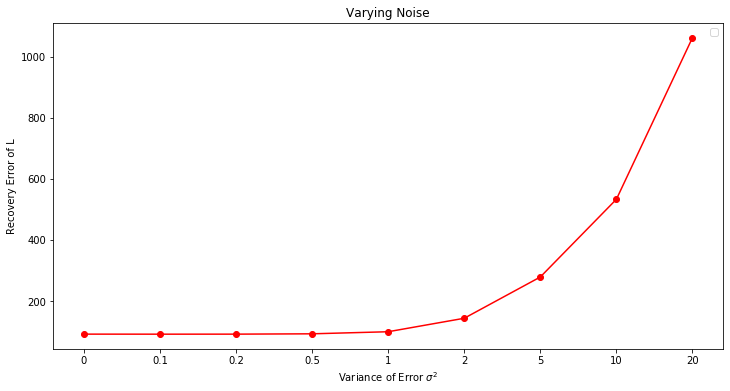

In [132]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 计算平均误差
errLsub_mean = np.mean(errLsub_, axis=1)
sigma_2 = ['0', '0.1', '0.2', '0.5', '1', '2', '5', '10', '20']
x = range(len(sigma_2))
plt.figure(figsize=(12,6))
plt.plot(x, errLsub_mean, 'r-o')      # https://zhuanlan.zhihu.com/p/110656183
plt.xticks(x, labels=sigma_2)
plt.xlabel('Variance of Error $\sigma^2$') 
plt.ylabel('Recovery Error of L')
plt.title('Varying Noise')
plt.legend(loc = 'upper right') #简单的设置legend(设置位置),位置在右上角
plt.show()

### 绘图$\sigma^2$与高维$S$恢复误差

<Figure size 864x432 with 0 Axes>

([<matplotlib.axis.XTick at 0x12c797ed0>,
 <a list of 9 Text xticklabel objects>)

Text(0.5, 0, 'Variance of Error $\\sigma^2$')

Text(0, 0.5, 'Recovery Error of S')

Text(0.5, 1.0, 'Varying Noise')

No handles with labels found to put in legend.


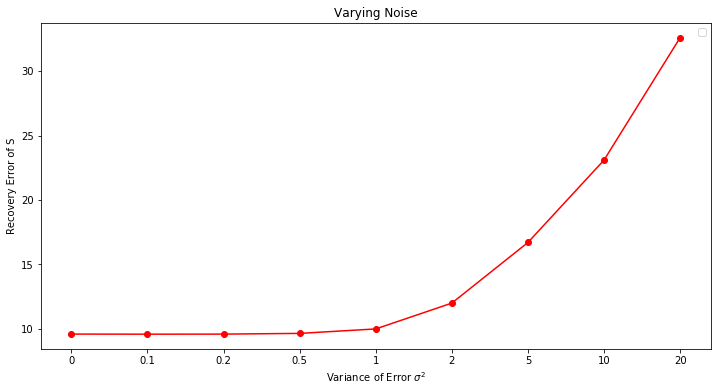

In [133]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 计算平均误差
errSfull_mean = np.mean(errSfull_, axis=1) # 按列求和axis=0, 按行求和axis=0, np.mean(x):全部元素求和
sigma_2 = ['0', '0.1', '0.2', '0.5', '1', '2', '5', '10', '20']
x = range(len(sigma_2))
plt.figure(figsize=(12,6))
plt.plot(x, errSfull_mean, 'r-o')      # https://zhuanlan.zhihu.com/p/110656183
plt.xticks(x, labels=sigma_2)
plt.xlabel('Variance of Error $\sigma^2$') 
plt.ylabel('Recovery Error of S')
plt.title('Varying Noise')
plt.legend(loc = 'upper right') #简单的设置legend(设置位置),位置在右上角
plt.show()

## $k$与低秩$L$和高维$S$恢复误差

In [137]:
k_all = [2, 5, 10, 20, 50, 100]
len_ = len(k_all) #计算sigma的长度
kre_low_rank = np.zeros((len_, 10))  # 将误差的存放数组初始化
kerrLsub_ = np.zeros((len_, 10))
kerrSfull_ = np.zeros((len_, 10))
for i in range(len_):
    for j in range(10):
        Z,A,W,b,E = ini_x_(n=100, k = k_all[i], p=200, seed=6666, sigma=1, ratio=0.9)
        L_true = np.dot(Z, A)
        S_true = W * b.T
        X = np.dot(Z,A) + W*b.T + E
        bestErr, errLsub, errSfull = hybrid_sl_wrapper_oracle(X,k,L_true,S_true)[-3:]
        kre_low_rank[i,j]= bestErr
        kerrLsub_[i,j] = errLsub[-1, -1]
        kerrSfull_[i,j] = errSfull[-1, -1]
kre_low_rank = np.sqrt(kre_low_rank)
kerrLsub_ = np.sqrt(kerrLsub_)
kerrSfull_ = np.sqrt(kerrLsub_)    


### 绘图$k$与低秩$L$恢复误差

<Figure size 864x432 with 0 Axes>

([<matplotlib.axis.XTick at 0x12b822c90>,
 <a list of 6 Text xticklabel objects>)

Text(0.5, 0, 'Low-rank dimension $k$')

Text(0, 0.5, 'Recovery Error of L')

Text(0.5, 1.0, 'Varying Dimensionality')

No handles with labels found to put in legend.


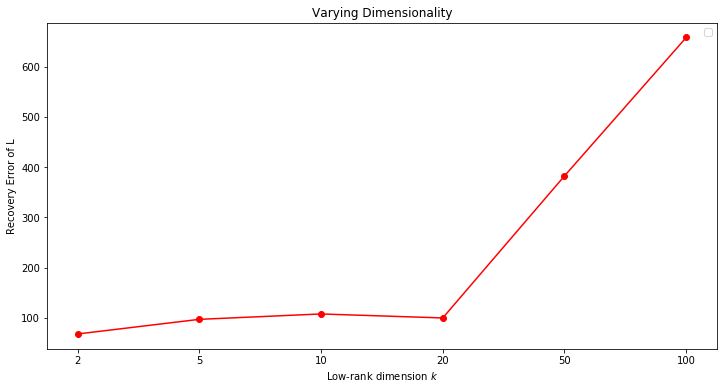

In [138]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 计算平均误差
kerrLsub_mean = np.mean(kerrLsub_, axis=1)
k_ = ['2','5', '10', '20', '50', '100']
x = range(len(k_))
plt.figure(figsize=(12,6))
plt.plot(x, kerrLsub_mean, 'r-o')      # https://zhuanlan.zhihu.com/p/110656183
plt.xticks(x, labels=k_)
plt.xlabel('Low-rank dimension $k$') 
plt.ylabel('Recovery Error of L')
plt.title('Varying Dimensionality')
plt.legend(loc = 'upper right') #简单的设置legend(设置位置),位置在右上角
plt.show()

### 绘图$k$与高维$S$恢复误差

<Figure size 864x432 with 0 Axes>

([<matplotlib.axis.XTick at 0x12c9510d0>,
 <a list of 6 Text xticklabel objects>)

Text(0.5, 0, 'Low-rank dimension $k$')

Text(0, 0.5, 'Recovery Error of S')

Text(0.5, 1.0, 'Varying Dimensionality')

No handles with labels found to put in legend.


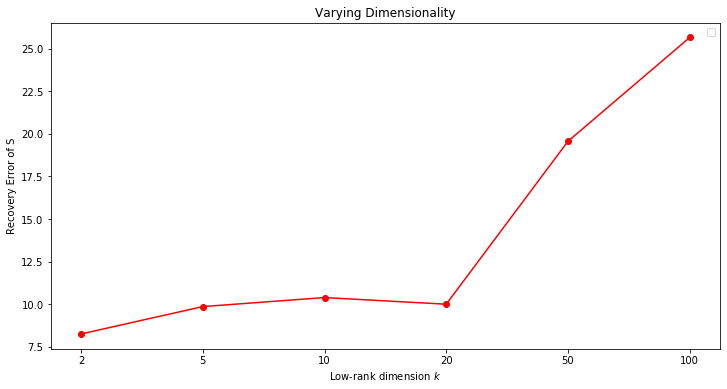

In [139]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 计算平均误差
kerrSfull_mean = np.mean(kerrSfull_, axis=1)
k_ = ['2','5', '10', '20', '50', '100']
x = range(len(k_))
plt.figure(figsize=(12,6))
plt.plot(x, kerrSfull_mean, 'r-o')      # https://zhuanlan.zhihu.com/p/110656183
plt.xticks(x, labels=k_)
plt.xlabel('Low-rank dimension $k$') 
plt.ylabel('Recovery Error of S')
plt.title('Varying Dimensionality')
plt.legend(loc = 'upper right') #简单的设置legend(设置位置),位置在右上角
plt.show()

## $\theta$与低秩$L$和高维$S$恢复误差

In [144]:
ratio_all = 0.1 * np.arange(10,0, -1)
len_ = len(ratio_all) #计算sigma的长度
theta_re_low_rank = np.zeros((len_, 10))  # 将误差的存放数组初始化
theta_errLsub_ = np.zeros((len_, 10))
theta_errSfull_ = np.zeros((len_, 10))
for i in range(len_):
    for j in range(10):
        Z,A,W,b,E = ini_x_(n=100, k=20, p=200, seed=6666, sigma=0.9, ratio = ratio_all[i])
        L_true = np.dot(Z, A)
        S_true = W * b.T
        X = np.dot(Z,A) + W*b.T + E
        bestErr, errLsub, errSfull = hybrid_sl_wrapper_oracle(X,k,L_true,S_true)[-3:]
        theta_re_low_rank[i,j]= bestErr
        theta_errLsub_[i,j] = errLsub[-1, -1]
        theta_errSfull_[i,j] = errSfull[-1, -1]
theta_re_low_rank = np.sqrt(theta_re_low_rank)
theta_errLsub_ = np.sqrt(theta_errLsub_)
theta_errSfull_ = np.sqrt(theta_errSfull_) 

### 绘图$\theta$与低秩$L$恢复误差

<Figure size 864x432 with 0 Axes>

([<matplotlib.axis.XTick at 0x1202a6950>,
 <a list of 10 Text xticklabel objects>)

Text(0.5, 0, 'Participation in LowR $\theta_1$')

Text(0, 0.5, 'Recovery Error of L')

Text(0.5, 1.0, 'Varying Split of LowR v. HighD')

No handles with labels found to put in legend.


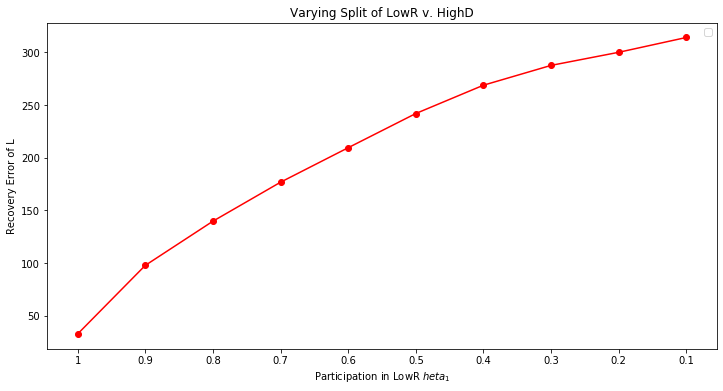

In [145]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 计算平均误差
theta_errLsub_mean = np.mean(theta_errLsub_, axis=1)
ratio_ = ['1','0.9', '0.8', '0.7', '0.6', '0.5', '0.4', '0.3', '0.2','0.1']
x = range(len(ratio_))
plt.figure(figsize=(12,6))
plt.plot(x, theta_errLsub_mean, 'r-o')      # https://zhuanlan.zhihu.com/p/110656183
plt.xticks(x, labels=ratio_)
plt.xlabel('Participation in LowR $\theta_1$') 
plt.ylabel('Recovery Error of L')
plt.title('Varying Split of LowR v. HighD')
plt.legend(loc = 'upper right') #简单的设置legend(设置位置),位置在右上角
plt.show()

### 绘图$\theta$与低秩$L$恢复误差

<Figure size 864x432 with 0 Axes>

([<matplotlib.axis.XTick at 0x122736510>,
 <a list of 10 Text xticklabel objects>)

Text(0.5, 0, 'Participation in LowR $\theta_1$')

Text(0, 0.5, 'Recovery Error of S')

Text(0.5, 1.0, 'Varying Split of LowR v. HighD')

No handles with labels found to put in legend.


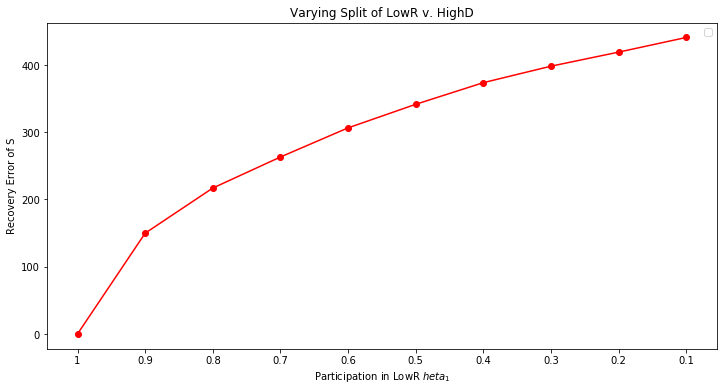

In [146]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 计算平均误差
theta_errSfull_mean = np.mean(theta_errSfull_, axis=1)
ratio_ = ['1','0.9', '0.8', '0.7', '0.6', '0.5', '0.4', '0.3', '0.2','0.1']
x = range(len(ratio_))
plt.figure(figsize=(12,6))
plt.plot(x, theta_errSfull_mean, 'r-o')      # https://zhuanlan.zhihu.com/p/110656183
plt.xticks(x, labels=ratio_)
plt.xlabel('Participation in LowR $\theta_1$') 
plt.ylabel('Recovery Error of S')
plt.title('Varying Split of LowR v. HighD')
plt.legend(loc = 'upper right') #简单的设置legend(设置位置),位置在右上角
plt.show()